# Building a dataset of motor vehicle accidents affecting pedestrian/bicylist youth in Indianapolis

**Daniel P. Riggins, MD**

## Rationale 

Road injuries are the [leading cause of mortality](http://ihmeuw.org/4xvn) in Indiana youth between the ages of 5-17. As a resident pediatrician at Riley Hospital for Children--the only level 1 trauma center for children in Indiana--I have seen firsthand the devastating after-effects of these accidents. In the interest of prevention, I have two main goals:

1. Build our capacity to predict where and when such accidents will happen
2. Evaluate what methods for prevention are most effective

I am also deeply passionate about two other issues: fostering regular physical activity and limiting human contributions to climate change. All these issues coalesce around walking or biking to school, which is a great way to build exercise into your daily routine while reducing use of fossil-fuel burning vehicles. Currently, the practice of actively commuting to school is uncommon, perhaps especially in car-centric cities like Indianapolis. I have asked parents about this and their explanations are many, but one common theme is their fear for their children's safety. Maybe if we could prevent more street accidents from happening, not only could we reduce the amount of needless death, we could also increase their likelihood to actively commute to school and other important locations in their lives.

## Overview

Language: I am using the guiding mission above to develop my skills in data science coding. I have chosen to use Julia as my language of choice, which is lesser known than its cousins Python and R, but brings its own intrinsic benefits. Check out [this blog post](https://medium.com/@thomascherickal/will-julia-replace-python-and-r-as-a-data-science-tool-897efcf18b73) for a fairly balanced rundown on the advantages and disadvantages of Julia. 

Data: For now, I'm deriving all my data from the ARIES database, which is a repository maintained by the Indiana State Police regarding all road crashes that take place in the state. It has a well-maintained API you can learn about [here](https://hub.mph.in.gov/dataset/aries-crash-data-2007-2017).

We'll start out by showing how anybody with Julia installed on their computer can pull ARIES data from the cloud and consolidate it into a single dataframe for analysis. Given my personal locus of interest and influence in advocacy, I have chosed the following constraints:

- Accidents pertain only to those involving a pedestrian or bicyclist
- Victims are between the ages of 1 and 24 years old
- Locations of crashes are limited to Marion County (home of Indianapolis) and all of its surrounding neighbors

Ok, let's get started. If you're not interested in the coding aspect of this work, no worries, just skip to the next block of text.

In [1]:
# Form an array with dataset ID's for each year

#=
The first six years do not return any results from the SQL query outlined one cell below:

d2007 = "994487c5-5d44-4fb9-ae9d-84ca75659bf0"
d2008 = "e4e56445-8cb6-4fc5-955c-7a2331684279"
d2009 = "881391be-d712-44b4-bfd0-ef9f018a4e4b"
d2010 = "46eb8985-f5b5-4635-9d6c-769dbd05fa02"
d2011 = "32ecfbfa-cf4b-4f64-af48-e1a624ae5ba4"
d2012 = "c2727405-925d-48fe-a8c1-06058ee65a25"
=#

d2013 = "ca9adbd5-001e-49e7-a850-f9f3471eb2db"
d2014 = "a5262209-109c-49cd-b6a9-a72970dc1cf5"
d2015 = "7fd801c4-4cf3-4e18-a949-a4d21401d798"
d2016 = "88646815-5b52-433b-9609-c75500e48e4c"
d2017 = "911880b1-d0bb-4168-a5c1-a52dcc291445"
d2018 = "cc90589c-72d8-4d92-a5fe-73254b555c73"

dARIES = [d2013,d2014,d2015,d2016,d2017,d2018]

6-element Array{String,1}:
 "ca9adbd5-001e-49e7-a850-f9f3471eb2db"
 "a5262209-109c-49cd-b6a9-a72970dc1cf5"
 "7fd801c4-4cf3-4e18-a949-a4d21401d798"
 "88646815-5b52-433b-9609-c75500e48e4c"
 "911880b1-d0bb-4168-a5c1-a52dcc291445"
 "cc90589c-72d8-4d92-a5fe-73254b555c73"

In [2]:
#For each dataset, send the URL-encoded SQL query below that filters by age, mode of travel, and location. Convert the response into JSON, then into a local dataframe, then append it onto the global dataframe.

#=
SELECT * from "[DATASET]"
    WHERE "PERSONTYPEDESCR" IN ('Pedal Cyclist','Pedestrian') 
    AND "AGE_GRP" IN ('1-4 Years','5-14 Years','15-24 Years')
=#

using DataFrames, HTTP, JSON

df = DataFrame()

for dataset in dARIES
    try
        address = string("https://hub.mph.in.gov/api/3/action/datastore_search_sql?sql=SELECT%20*%20from%20%22",dataset,"%22%20WHERE%20%22PERSONTYPEDESCR%22%20IN%20(%27Pedal%20Cyclist%27,%27Pedestrian%27)%20AND%20%22AGE_GRP%22%20IN%20(%271-4%20Years%27,%275-14%20Years%27,%2715-24%20Years%27)")
        response = HTTP.get(address)
        rawData = response.body |> String |> JSON.parse
        records = rawData["result"]["records"]
        locdf = DataFrame()
        for key in keys(first(records))
            locdf[!,Symbol(key)] = [record[key] for record in records]
        end
        df = vcat(df,locdf)
    catch
        @warn "Error thrown, will skip to next dataset!"
    end
end

#Thanks to @rdeits on Discourse for helping write a loop that constructs the dataframe by column rather than by row

┌ Warning: Error thrown, will skip to next dataset!
└ @ Main In[2]:25
┌ Warning: Error thrown, will skip to next dataset!
└ @ Main In[2]:25


In [3]:
# Write to CSV

using CSV

something.(df, missing) |> CSV.write("compositeARIES1.csv")

"compositeARIES1.csv"

## Let's use that data!

Ok, so we've pulled our data from the cloud and now it's sitting in a CSV file available for analysis.

Now let's use this data to visualize where crashes are taking place around Indianapolis.

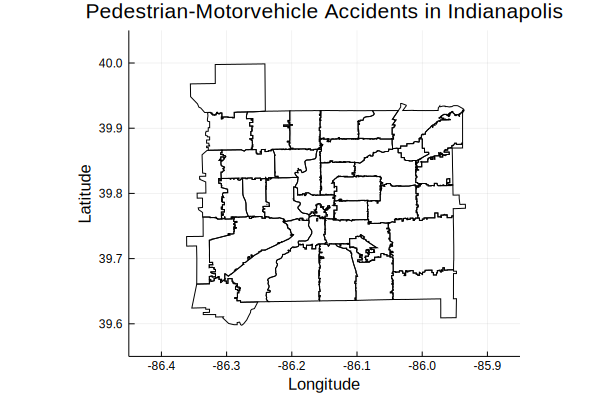

In [4]:
# Plot zipcodes of Indianapolis for the base layer of our visualization

using StatsPlots, HTTP, GeoJSON

response = HTTP.get("https://opendata.arcgis.com/datasets/bba987ced0cf4b7086650e3656b30d69_7.geojson")
zipCodes = GeoJSON.parse(String(response.body))

StatsPlots.plot(zipCodes, title="Pedestrian-Motorvehicle Accidents in Indianapolis", xlabel="Longitude", ylabel="Latitude", xlims = (-86.45,-85.85), ylims= (39.55,40.05), fill=nothing)

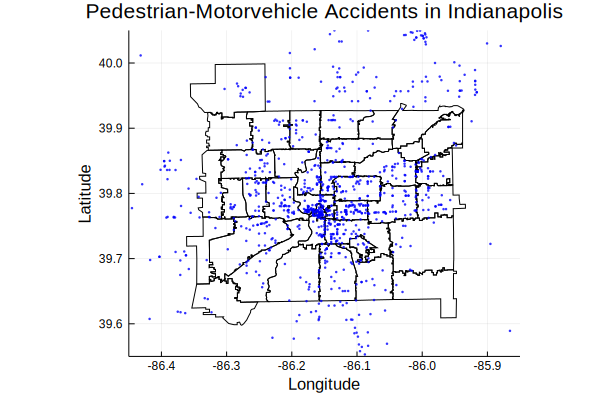

In [5]:
# Overlay the sites of accidents

using DataFramesMeta

df = CSV.read("compositeARIES.csv") |> DataFrame
dropmissing!(df,[:LONGDECIMALNMB,:LATDECIMALNMB])
@df df scatter!(:LONGDECIMALNMB, :LATDECIMALNMB, markercolor=:blue, markersize=1.5, markeralpha=0.8, markerstrokealpha=0)

## That's all so far

Hopefully this is just the start of some deeper dives into crash prevention around the Indianapolis area. Stay tuned!